In [19]:
# Data handling
import pickle
import pandas as pd

# Types handling
import numpy as np
from fractions import Fraction

# Data science
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine learning tool
import xgboost as xgb
# Optimization / feature engineering tools
import optuna

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Smart options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [20]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

In [21]:
X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

Y_train_observed_a = pd.read_parquet('../A/train_targets.parquet')
Y_train_observed_b = pd.read_parquet('../B/train_targets.parquet')
Y_train_observed_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

In [22]:
X_train_observed_a.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118669,118669.000000,118669.000000,96422.000000,1.186690e+05,118669.000000,110603.000000,118669.000000,118669.000000,118669.000000,1.186690e+05,118669.000000,1.186690e+05,118669.000000,118669.0,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,2724.0,118669.000000,118669.0,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000
mean,2021-02-09 23:30:00,6.652576,1.249064,2907.949219,5.994018e+05,166.500381,1737.142212,0.022398,276.823395,44.918282,1.617057e+05,56.611744,2.038025e+05,67.605507,6.0,0.053117,0.004418,0.106243,0.013277,0.026567,0.521391,0.511650,1009.632996,0.006302,0.091018,996.765381,1002.868225,0.187399,0.011914,74.231705,1008.998352,250.0,0.052763,0.0,0.000062,0.091566,179.629486,1.529545,0.059087,280.708557,74.401077,32446.992188,3.043197,0.756781,0.517437,0.000019
min,2019-06-02 22:00:00,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.299988,0.000000,0.000000,932.299988,938.099976,0.000000,0.000000,22.700001,943.900024,250.0,0.000000,0.0,-0.000000,0.000000,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-04-06 22:45:00,4.400000,1.224000,1102.900024,0.000000e+00,0.000000,590.700012,0.000000,272.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,43.299999,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1002.099976,0.000000,0.000000,989.299988,995.299988,0.000000,0.000000,65.000000,1001.400024,250.0,0.000000,0.0,0.000000,0.000000,88.487999,-15.066000,0.000000,275.899994,54.799999,15592.400391,1.700000,-1.400000,-0.700000,0.000000
50%,2021-02-09 23:30:00,6.300000,1.247000,1882.400024,3.574770e+04,8.600000,1162.599976,0.000000,277.200012,4.100000,2.481410e+04,0.000000,8.960000e+01,80.500000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1010.700012,0.000000,0.000000,997.900024,1003.900024,0.000000,0.000000,76.699997,1010.000000,250.0,0.000000,0.0,0.000000,0.000000,179.436996,1.202000,0.000000,280.700012,93.699997,36359.800781,2.700000,0.400000,0.500000,0.000000
75%,2021-12-16 00:15:00,8.600000,1.272000,3969.750000,1.037819e+06,288.799988,2079.600098,0.000000,282.000000,76.000000,2.743256e+05,41.799999,1.598314e+05,98.800003,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1018.299988,0.000000,0.000000,1005.400024,1011.500000,0.000000,0.000000,85.400002,1017.599976,250.0,0.000000,0.0,0.000000,0.100000,270.640991,18.995001,0.100000,285.200012,99.900002,48084.500000,4.100000,2.700000,1.700000,0.000000
max,2022-10-21 01:00:00,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,688.700012,2.451173e+06,100.000000,6.0,15.100000,3.900000,15.100000,7.900000,14.800000,1.000000,1.000000,1044.000000,2.230000,6.000000,1

In [23]:
X_train_concat = pd.concat([X_train_observed_a, X_train_estimated_a], ignore_index=True)

In [24]:
X_train_group = X_train_concat.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean().reset_index()
X_train_group.rename(columns={"date_forecast":"time"}, inplace=True)

In [25]:
X_train_group.tail()

,time,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
34269,2023-04-30 19:00:00,4.55,1.27650,1674.199951,84464.945312,4.225,542.700012,0.0,272.424988,2.825,56431.050781,0.1,13230.649414,96.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.5,0.75,1014.750000,0.0,0.0,1001.574951,1007.799988,0.0,0.0,74.625000,1014.049988,NaN,0.0,0.0,0.0,0.000,304.939240,-0.18050,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,2023-04-29 07:00:05
34270,2023-04-30 20:00:00,4.50,1.27975,1762.400024,2270.875000,0.000,546.400024,0.0,272.299988,0.000,5067.875000,0.0,176.350006,94.224998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.700012,0.0,0.0,1001.549988,1007.799988,0.0,0.0,76.875000,1014.049988,NaN,0.0,0.0,0.0,0.000,318.625763,-5.17600,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,2023-04-29 07:00:05
34271,2023-04-30 21:00:00,4.50,1.28100,1696.650024,0.000000,0.000,548.349976,0.0,272.299988,0.000,0.000000,0.0,0.000000,94.324997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.549988,0.0,0.0,1001.400024,1007.674988,0.0,0.0,77.775002,1013.925049,NaN,0.0,0.0,0.0,0.000,332.785736,-8.95075,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,2023-04-29 07:00:05
34272,2023-04-30 22:00:00,4.50,1.28100,1353.400024,0.000000,0.000,527.775024,0.0,272.299988,0.000,0.000000,0.0,0.000000,97.775002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.400024,0.0,0.0,1001.250000,1007.500000,0.0,0.0,79.000000,1013.799988,NaN,0.0,0.0,0.0,0.025,347.377991,-11.23325,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,2023-04-29 07:00:05
34273,2023-04-30 23:00:00,4.50,1.28100,1626.574951,0.000000,0.000,526.525024,0.0,272.274994,0.000,0.000000,0.0,0.000000,98.425003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.049988,0.0,0.0,1000.875000,1007.099976,0.0,0.0,79.849998,1013.400024,NaN,0.0,0.0,0.0,0.050,92.209503,-11.84150,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,2023-04-29 07:00:05


In [26]:
inner_merge = pd.merge(X_train_group, Y_train_observed_a, on="time", how="inner")

In [27]:
inner_merge.dtypes

time                              datetime64[us]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm                         float32
is_day:idx          

# Data cleaning and 

In [28]:
inner_to_split = inner_merge.copy().drop(columns=["time", "date_calc"])
id_columns = [c for c in inner_to_split.columns if ":idx" in c]
non_id_columns = [c for c in inner_to_split.columns if ":id" not in c and "date" not in c]

# inner_to_split[id_columns] = inner_to_split[id_columns].astype("category")
inner_to_split.fillna(0, inplace=True)

inner_to_split[id_columns] = inner_to_split[id_columns].astype("float")
inner_to_split[non_id_columns] = inner_to_split[non_id_columns].astype("float")

# for column in id_columns:
    # inner_to_split[column] = inner_to_split[column].apply(lambda x: Fraction(x).limit_denominator())

X = inner_to_split[[c for c in inner_to_split.columns if c != "pv_measurement"]]
Y = inner_to_split["pv_measurement"]
inner_to_split[id_columns].to_csv("hei.csv")


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.25)

In [30]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

In [31]:
# params = {'max_depth':2, 'eta':1, 'silent':1, "objective": "reg:squarederror", "tree_method": "gpu_hist"}
params = {"objective": "reg:squarederror", "tree_method": "auto"}
n = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250,
   early_stopping_rounds=50
)

[0]	validation-rmse:864.19049	train-rmse:884.52190
[250]	validation-rmse:409.28446	train-rmse:90.96765
[500]	validation-rmse:409.73170	train-rmse:36.28638
[750]	validation-rmse:409.35871	train-rmse:17.00983
[1000]	validation-rmse:409.26987	train-rmse:9.33501
[1250]	validation-rmse:409.16163	train-rmse:5.50194
[1500]	validation-rmse:409.12176	train-rmse:3.45796
[1750]	validation-rmse:409.09942	train-rmse:2.27851
[2000]	validation-rmse:409.09110	train-rmse:1.61606
[2250]	validation-rmse:409.09589	train-rmse:1.26418
[2500]	validation-rmse:409.09291	train-rmse:1.07998
[2750]	validation-rmse:409.09189	train-rmse:0.98749
[3000]	validation-rmse:409.08999	train-rmse:0.94784
[3250]	validation-rmse:409.08940	train-rmse:0.93092
[3500]	validation-rmse:409.08908	train-rmse:0.92334
[3750]	validation-rmse:409.08924	train-rmse:0.92022
[4000]	validation-rmse:409.08899	train-rmse:0.91890
[4250]	validation-rmse:409.08920	train-rmse:0.91837
[4500]	validation-rmse:409.08925	train-rmse:0.91812
[4750]	valida

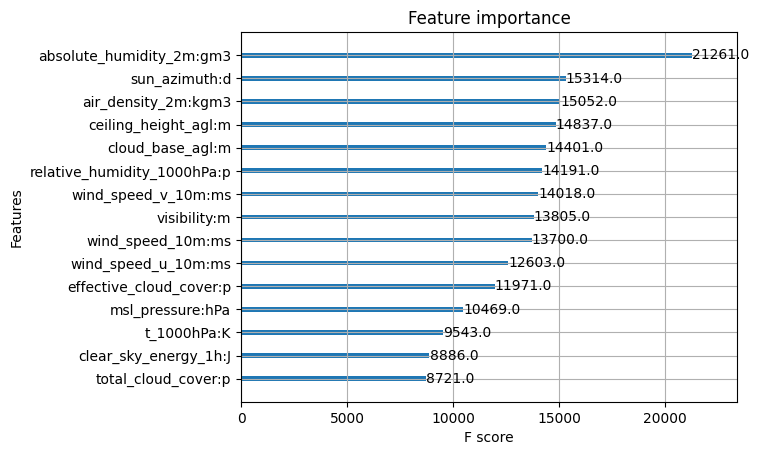

In [32]:
xgb.plot_importance(model,max_num_features=15)
plt.show()

In [33]:
preds = model.predict(dtest_reg)

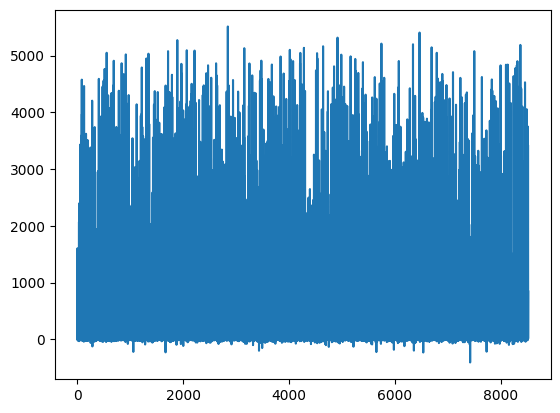

In [34]:
plt.plot(preds)

In [35]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 409.089


# Tuning

In [44]:
label_encoder = LabelEncoder()
sc = StandardScaler()
X_train, y_train = sc.fit_transform(X_train), label_encoder.fit_transform(y_train)

In [45]:
len(X_train), len(y_train)

(25563, 25563)

In [46]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [47]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-09-27 11:02:05,737] A new study created in memory with name: regression
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/dat

In [48]:
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  1790058.6156912341
R2:  -0.37367823328159977
RMSE:  1337.930721558943


/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed 

In [49]:
filename = "xgbregressor.pkl"
pickle.dump(model, open(filename, "wb"))